# Import Libraries

In [40]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import re, seaborn as sns

# Step 1: Load Data

In [41]:
df=pd.read_csv('labeled_data.csv', index_col=None)
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Step 2: Clean Data

In [42]:
df = df[['class','tweet']]
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [43]:
df = df.replace({2:0})
df.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [44]:
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'^!?[!]*\s*RT\s+@\w+:\s*','', x))
df.head()

,class,tweet
0,0,As a woman you shouldn't complain about cleani...
1,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,@viva_based she look like a tranny
4,1,The shit you hear about me might be true or it...


In [45]:
# Clean the tweets
def clean_tweet(text):
    text = re.sub(r'RT\s+@\w+:\s*', '', text)      # Remove "RT @username:"
    text = re.sub(r'@\w+', '', text)              # Remove mentions
    text = re.sub(r'[!?]{2,}', '', text)          # Remove repeated ! or ?
    text = re.sub(r'\s+', ' ', text).strip()      # Remove extra spaces
    return text

In [46]:
df['tweet'] = df['tweet'].apply(clean_tweet)
df.head()

,class,tweet
0,0,As a woman you shouldn't complain about cleani...
1,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,1,RT Dawg You ever fuck a bitch and she start to...
3,1,she look like a tranny
4,1,The shit you hear about me might be true or it...


# Step 3: Balance the Dataset

In [47]:
# Check whether the dataset is balanced
from collections import Counter
Counter(df['class'])

Counter({1: 19190, 0: 5593})

In [48]:
from sklearn.utils import resample

count_class = len(df[df['class'] == 0])

# Split the data into class 0 and class 1
df_class_0 = df[df['class'] == 0]
df_class_1 = df[df['class'] == 1]

# Undersample 
df_class_1_undersampled = resample(df_class_1,
                                   replace=False,    
                                   n_samples=count_class, 
                                   random_state=42) 

# Combine the undersampled class 0 with class 1
df_balanced = pd.concat([df_class_1_undersampled, df_class_0])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced

,class,tweet
0,0,"Okay, so maybe not every in #LosAngeles is evi..."
1,0,yall defense too trash for that &#128514;&#128...
2,0,"Bitch ass nigga, be hating on black women... U..."
3,1,My bitches not average. Spend money I got it. ...
4,1,Youzza bitch
...,...,...
11181,0,#HellYeah RT #No RT Happy Fall! Pumpkin Spice ...
11182,1,My bitch sad lookin like a lack of funny
11183,1,""": &#8220;: Don't take advantage of a nice per..."
11184,1,"I lost it. ""you think you're too good for me? ..."


In [49]:
y=df_balanced["class"]

In [50]:
# Split the dataset into train and test¶
X_train, X_test, y_train, y_test = train_test_split(df_balanced['tweet'], y, test_size=0.33, random_state=53)

# Step 4:Convert text to vector format

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
vectorizer = count_vectorizer.fit(X_train)

count_train = vectorizer.transform(X_train)
#print(count_train.shape, count_train)
count_test = vectorizer.transform(X_test)

In [52]:
import joblib
joblib.dump(vectorizer, 'countvector.pkl')

['countvector.pkl']

# Step 5:Train the model 

In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(count_train, y_train)

pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)


accuracy:   0.879


In [54]:
joblib.dump(clf, 'model.pkl')

['model.pkl']

# Step 6:Evaluating the performance

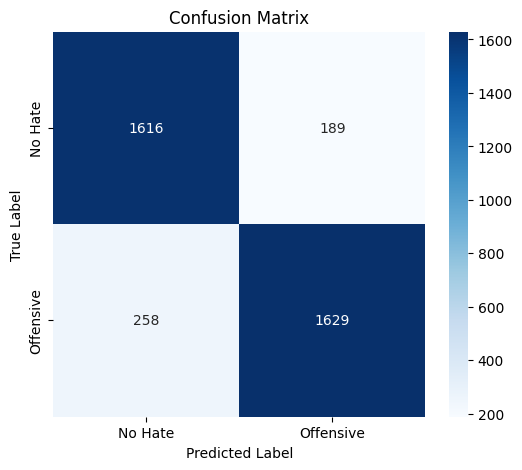

In [55]:
cm = metrics.confusion_matrix(y_test, pred)
# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Hate', 'Offensive'], yticklabels=['No Hate', 'Offensive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [56]:
from sklearn.metrics import classification_report

report=classification_report(y_test, pred)

In [57]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1805
           1       0.90      0.86      0.88      1887

    accuracy                           0.88      3692
   macro avg       0.88      0.88      0.88      3692
weighted avg       0.88      0.88      0.88      3692



# Step 7:Predict from trained model

In [82]:
text= '!! @abc hi hello how are you'
df = pd.DataFrame([text], columns=["text"])
df['text'] = df['text'].apply(lambda x: re.sub(r'^!?[!]*\s*RT\s+@\w+:\s*','', x))
# Clean the tweets
def clean_tweet(text):
    text = re.sub(r'RT\s+@\w+:\s*', '', text)      # Remove "RT @username:"
    text = re.sub(r'@\w+', '', text)              # Remove mentions
    text = re.sub(r'[!?]{2,}', '', text)          # Remove repeated ! or ?
    text = re.sub(r'\s+', ' ', text).strip()      # Remove extra spaces
    return text

df['text'] = df['text'].apply(clean_tweet)
df.head()

count_vectorizer = joblib.load('countvector.pkl')
vector_inp = count_vectorizer.transform(df['text'])

model = joblib.load('model.pkl')
model.predict(vector_inp)

array([0])